<a href="https://colab.research.google.com/github/Charltec/Final/blob/main/Machine_Learning_Final_Charlie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [219]:
# Import libraries
import math 
# It helps to code tables and graphs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [220]:
# Let the program read de data frame we implemented
data = 'https://raw.githubusercontent.com/Charltec/Final/main/diabetes.csv'
data_frame =  pd.read_csv(data)
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [221]:
# Table of the dataframe
data_frame.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [222]:
# Erase all the incomplete data
data_frame = data_frame[-(data_frame[data_frame.columns[1:-1]] == 0).any(axis=1)]
data_frame = data_frame[['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']] 
# Data frame with no empty data
data_frame.head()

,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,89,94,28.1,0.167,21,0
4,137,168,43.1,2.288,33,1
6,78,88,31.0,0.248,26,1
8,197,543,30.5,0.158,53,1
13,189,846,30.1,0.398,59,1


In [223]:
"""
Data frame description (Descriptive statistics include those that summarize the 
central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.)
"""
data_frame.describe()

,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,122.627551,156.056122,33.086224,0.523046,30.864796,0.331633
std,30.860781,118.841690,7.027659,0.345488,10.200777,0.471401
min,56.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,99.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,119.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,143.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,198.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [224]:
# Drop the parameter Outcome cause its nos essential for our analysis
x = data_frame.drop('Outcome', axis=1)
print(x)

y = data_frame['Outcome']
y = y.values
#print(y)

     Glucose  Insulin   BMI  DiabetesPedigreeFunction  Age
3         89       94  28.1                     0.167   21
4        137      168  43.1                     2.288   33
6         78       88  31.0                     0.248   26
8        197      543  30.5                     0.158   53
13       189      846  30.1                     0.398   59
..       ...      ...   ...                       ...  ...
753      181      510  43.3                     0.222   26
755      128      110  36.5                     1.057   37
760       88       16  28.4                     0.766   22
763      101      180  32.9                     0.171   63
765      121      112  26.2                     0.245   30

[392 rows x 5 columns]


In [225]:
# Parameters for feature selection
feature_name = list(x.columns)
# no of maximum features we need to select
num_feats=5

In [226]:
# Pearson correlation
'''
This is a filter-based method.  We check the absolute value of the Pearson's correlation between the target and numerical features 
in our dataset. We keep the top n features based on this criterion.
'''
def cor_selector(x, y,num_feats):
    cor_list = []
    feature_name = x.columns.tolist()
    # calculate the correlation with y for each feature
    for i in x.columns.tolist():
        cor = np.corrcoef(x[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(x, y,num_feats)

In [227]:
# Chi-Square Features
'''
This is another filter-based method.  In this method, we calculate the chi-square metric between the target and the
numerical variable and only select the variable with the maximum chi-squared values.
'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(x)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = x.loc[:,chi_support].columns.tolist()

In [228]:
# Recursive Feature Elimination
'''
The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller 
sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either 
through a coef_ attribute or through a featureimportances attribute. 
Then, the least important features are pruned from current set of features. That procedure is 
recursively repeated on the pruned set until the desired number of features to select is eventually reached.
'''
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = x.loc[:,rfe_support].columns.tolist()

In [229]:
# Lasso: SelectFromMode
'''
This is an Embedded method. As said before, Embedded methods use algorithms that have built-in feature selection methods.  
For example, Lasso, and RF have their own feature selection methods.
Lasso Regularizer forces a lot of feature weights to be zero.  Here we use Lasso to select variables.
'''
from sklearn.feature_selection import SelectFromModel

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = x.loc[:,embeded_lr_support].columns.tolist()

In [230]:
# Tree-based: SelectFromModel
'''
This is an Embedded method. As said before, Embedded methods use algorithms that have built-in feature selection methods. 
We can also use RandomForest to select features based on feature importance. 
We calculate feature importance using node impurities in each decision tree. 
In Random forest, the final feature importance is the average of all decision tree feature importance.
'''
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(x, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = x.loc[:,embeded_rf_support].columns.tolist()

In [231]:

# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,Glucose,True,True,True,True,True,5
2,Insulin,True,True,True,False,True,4
3,BMI,True,True,True,True,False,4
4,Age,True,True,True,True,False,4
5,DiabetesPedigreeFunction,True,True,True,False,False,3


In [232]:
# Model kfold
kfold = model_selection.KFold(n_splits=10, shuffle=True)
kfold_model = LogisticRegression()
kfold_results = model_selection.cross_val_score(kfold_model, x, y, cv=kfold)

In [233]:
print('Accuracy: %1f%%' % (kfold_results.mean()*100))

Accuracy: 78.564103%


<Figure size 432x288 with 0 Axes>

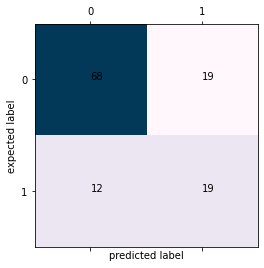

In [234]:
# It helps to know how many correct and incorrect answers our algorithm got
from sklearn import metrics
from sklearn.model_selection import train_test_split
kfold_model.fit(X_train,Y_train)
X_train,X_test,Y_train,Y_test = train_test_split(x, y, test_size=0.3, random_state=42)
prediction = kfold_model.predict(X_test)
'''
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, prediction)
# Recall
from sklearn.metrics import recall_score
recall_score(Y_test, prediction, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(Y_test, prediction, average=None)
'''
confusion_matrix = metrics.confusion_matrix(Y_test, prediction)
confusion_matrix

plt.figure()
plt.matshow(confusion_matrix, cmap='PuBu')

for x in range(0, 2):
    for y in range(0, 2):
        plt.text(x, y, confusion_matrix[x, y])

plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

#print(confusion_matrix)

In [235]:
# Posicion en la matriz
true_positive = confusion_matrix[1, 1]
print(true_positive)
true_negative = confusion_matrix[0, 0]
print(true_negative)
false_positive = confusion_matrix[0, 1]
print(false_positive)
false_negative = confusion_matrix[1, 0]
print(false_negative)

19
68
12
19


In [236]:
print("Sensitivity: %.2f" % (true_positive / float(true_positive + false_negative)))
print("Specificy  : %.2f" % (true_negative / float(true_negative + false_positive)))

Sensitivity: 0.50
Specificy  : 0.85


In [237]:
# Method: sklearn for F1 score
from sklearn.metrics import f1_score
#If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:
f1_score(Y_test, prediction, average=None)

array([0.81437126, 0.55072464])